# GS wavefunction and energy of 1dAFH
Solving under PBC, assuming TRS wavefunction.

Gauge transformation, \sigma_{2n+1} -> - \sigma_{2n+1}, leads to positive semi-definite wavefunction.

Codes by Nobuyuki Yoshioka, Feb 2018.

## Load the modules

In [1]:
import numpy as np
from RBM_1dHeisenberg import * # RBM class
from RealSamplingTools import * # Markov chain generator class
from VMC_1dHeisenberg import * # VMC scheme class

## Parameters

In [2]:
# System and hidden layer size
n_vis = 10 # system size
alpha = 2 # ratio of #hidden to #visible
n_batch = 100 # (#sample) for Gibbs sampling

# Parameters of Hamiltonian
J = 1 # Heisenberg interaction
Delta = 1 # XXZ anisotropy. Isotropic if Delta = 1.


# Learning hyperparameters
eta0 = 3e-2 # learning rate
power = 2
sigma = 0.001 # amplitude of random init. param
l2reg = 0. # L2 regularization

# Learning schedule
# lamb, lamb2 -> regularization factor of S matrix
Initlamb = 100 
decay = 0.98
lambmin = 1e-2

Initlamb2 = 1e-2
decay2 = 0.995
lamb2min = 1e-4
print "Lamb2 switch at iter = %d"%(np.log(lamb2min/Initlamb2)/np.log(decay2))

# Other optimization technique
momentum = 0. # momentum
dropout_p  = 0. # dropout-rate
threshold = 0.3 # threshold for S-matrix.
threshold2 = 30

Lamb2 switch at iter = 918


## Loading analytical expression of wave function

In [3]:
# Here, we use the Gauge-transformed Hamiltonian
# so that wave function is positive semi definite,
# allowing the alternate sampling from RBM.
from plottools_1dAFH import *
from RealWFtools import *
from ExactWaveFunc_1dHeisenberg import GSvec
from ExactWaveFunc_1dHeisenberg import EnPerSite_exact

# Prepare the basis of the vector.
# { |All up>, |uu...ud>, |uu...du>, ..., |All down>}
if n_vis <= 12:
    #Define gsvec_exact when it is undefined
    if not any(map(lambda x:x == 'gsvec_exact', locals())):
        gsvec_exact = GSvec(leng = n_vis, PBCflag = 1, hz = hz, hx = hx)
        
    # Re-calculate when n_vis is changed
    if int(np.log2(len(gsvec_exact))) != n_vis:
        gsvec_exact = GSvec(leng = n_vis, PBCflag = 1, hz = hz, hx = hx)
        
else: # But avoid if n_vis>12
    gsvec_exact = GSvec(leng = 10, PBCflag = 1, hz = hz, hx = hx)

# Calculate the exact GS energy
if not any(map(lambda x:x == 'enpersite_exact', locals())):
    if n_vis <= 12:
        enpersite_exact = EnPerSite_exact(n_vis, PBCflag = 1, hz = 0, hx = 0)/(n_vis*1.0)
    else:
        enpersite_exact = 4 * (-np.log(2) + 0.25)
if int(np.log2(len(gsvec_exact))) != n_vis:
    if n_vis <= 12:
        enpersite_exact = EnPerSite_exact(n_vis, PBCflag = 1, hz = 0, hx = 0)/(n_vis*1.0)
    else:
        enpersite_exact = 4 * (-np.log(2) + 0.25)

In [4]:
# Fixing the random seed
seed = 12345
np.random.seed(seed)

# "params" is saved together with the result.
params = np.array([n_vis, alpha,n_batch, J, hz, hx, Delta, eta0, sigma, l2reg, Initlamb, decay, lambmin, Initlamb2, decay2, lamb2min,
                      momentum, dropout_p, threshold, seed, threshold2])
param_contents = ['n_vis', 'alpha' , 'n_batch', 'J', 'hz', 'hx', 'Delta', 'eta0', 'sigma', 'l2reg', 'Initlamb', 'decay', 'lambmin', 'Initlamb2', 'decay2', 'lamb2min',
                      'momentum', 'dropout_p', 'threshold', 'seed', 'threshold2']

# Initialize vmc scheme.
vmc = VMC(n_vis = n_vis, alpha = alpha, eta = eta0, sigma = sigma, n_batch = n_batch,  J = J,
          l2reg = l2reg,  momentum = momentum, dropout_p = dropout_p, gsvec_exact= gsvec_exact, threshold = threshold, threshold2 = threshold2)
vmc.SetRBM()

# Optimizing GS energy by VMC

In [5]:
%%time

n_iter = 1500

EnPerSite = []
vmc.lamb = np.max(np.array([Initlamb , lambmin]))
vmc.lamb2 = np.max(np.array([Initlamb2 , lamb2min]))
for i in range(n_iter):
    vmc.lamb = np.max(np.array([Initlamb * decay **i, lambmin]))
    vmc.lamb2 = np.max(np.array([Initlamb2 * decay2**i, lamb2min]))
    vmc.eta = eta0 * ((n_iter - i)/(n_iter*1.0))**power
#    print "vmc.eta = ",vmc.eta
    
    vmc.run()
    if vmc.elocpersite != vmc.elocpersite:
        print "Divergence in calculation."
        break
    EnPerSite.append(vmc.elocpersite)

    if i%10 == 0:
        print "%d th iteration."%i
        vmc.PrintStats()

EnPerSite = np.array(EnPerSite)

# save the result with timestamp
d = datetime.datetime.today()

directory = 'Result/'
compflag = int(isinstance(vmc.rbm.a[0],complex)) # if the parameters are complex or not
Tsymmflag = int(hasattr(vmc.rbm, 'Wf')) # if the wavefunction is TRS or not

# Decide the name of the file according to the RBM type
predatename = PredateName(vmc,compflag, Tsymmflag)

# save the result
save_yaml(vmc, EnPerSite, params, param_contents, directory, predatename, d)

0 th iteration.
Eloc/site =  -1.014007246375964
10 th iteration.
Eloc/site =  -1.0609717842046646
20 th iteration.
Eloc/site =  -1.213316935913242
30 th iteration.
Eloc/site =  -1.3309327765902508
40 th iteration.
Eloc/site =  -1.3262000782774206
50 th iteration.
Eloc/site =  -1.4563047279928942
60 th iteration.
Eloc/site =  -1.4227485888063343
70 th iteration.
Eloc/site =  -1.464354190306975
80 th iteration.
Eloc/site =  -1.496335088509322
90 th iteration.
Eloc/site =  -1.5576224246419779
100 th iteration.
Eloc/site =  -1.5820620255059012
110 th iteration.
Eloc/site =  -1.6424972834213398
120 th iteration.
Eloc/site =  -1.641745386772395
130 th iteration.
Eloc/site =  -1.6590980304023257
140 th iteration.
Eloc/site =  -1.683711303050361
150 th iteration.
Eloc/site =  -1.6914069665252405
160 th iteration.
Eloc/site =  -1.6759626180784433
170 th iteration.
Eloc/site =  -1.7249542420675552
180 th iteration.
Eloc/site =  -1.7117352880574894
190 th iteration.
Eloc/site =  -1.70989027221859

Loading Result/real_Tsymm_10_2_20180213_152231.yml...


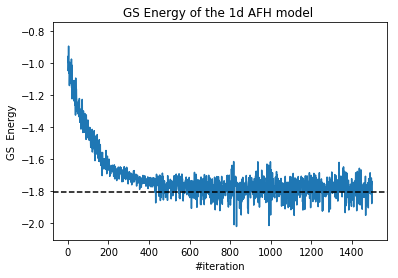

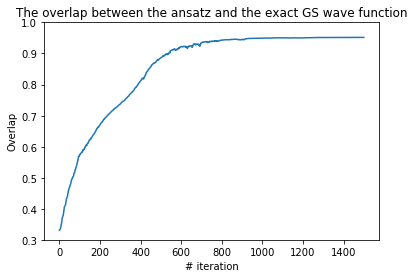

In [11]:
# load and plot the result
yamlname = directory + predatename + d.strftime("%Y%m%d_%H%M%S")
#yamlname = "Result/real_Tsymm_10_2_20180213_152231"

plot_yaml(yamlname)

In [7]:
print "Calculated EnPerSite: ",EnPerSite[-100:].mean()
print "Exact EnPerSite: ",enpersite_exact
Error = abs((EnPerSite[-100:].mean()- enpersite_exact)/enpersite_exact)
print "Error: ",Error

Calculated EnPerSite:  -1.842343881274325
Exact EnPerSite:  -1.806178541796817
Error:  0.02002312542232397


# Check and compare the wave function

In [8]:
n_digit = len(vmc.rbm.a)
dec_list = np.arange(2**n_digit)
AllSpinConfig = BinaryList(dec_list, n_digit)

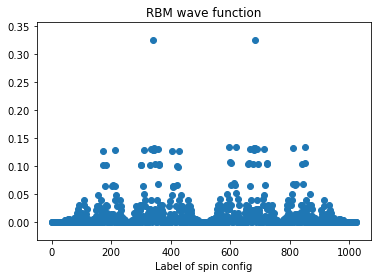

/Users/nobu/.pyenv/versions/anaconda2-4.3.1/lib/python2.7/site-packages/numpy/core/numeric.py:544: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


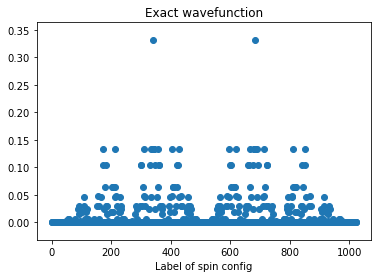

The most probable spin config. is  [-1.  1. -1.  1. -1.  1. -1.  1. -1.  1.]


In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

W_RBM = vmc.rbm.W
a_RBM = vmc.rbm.a
b_RBM = vmc.rbm.b

# Load the wavefunction
wavefunction_unnorm = map(lambda x: GSvec_raw(vmc.rbm, x),AllSpinConfig)
wavefunction = Normalize(wavefunction_unnorm)

# Plot the real amplitudes
#plt.scatter(np.arange(len(AllSpinConfig)),np.real(wavefunction_unnorm))
#plt.title("Real Part of RBM Wave function")
#plt.xlabel('Label of spin config')
#plt.show()

# Plot the imaginary amplitudes
#plt.scatter(np.arange(len(AllSpinConfig)),np.imag(wavefunction_unnorm))
#plt.title("Imaginary Part of RBM Wave function")
#plt.xlabel('Label of spin config')
#plt.show()

# Plot the Density
plt.scatter(np.arange(len(AllSpinConfig)),wavefunction)
plt.title("RBM wave function")
plt.xlabel('Label of spin config')
plt.show()

# Plot the exact wave function
plt.scatter(np.arange(len(AllSpinConfig)), -gsvec_exact)
plt.title("Exact wavefunction")
plt.xlabel('Label of spin config')
plt.show()


# return the spin configuration with largest amplitude
maxconfig = np.argmax(np.abs(wavefunction))
print "The most probable spin config. is ", AllSpinConfig[maxconfig]

In [10]:
# In order of GSvec amplitude
c = zip(wavefunction, np.arange(len(AllSpinConfig)))
c.sort(reverse = True)
wavefunction_sorted, sorted_order = zip(*c)

# Spin config with top ten amplitudes
print "The spin config. of ten largest wave function amplitudes are "
for j in range(20):
    fig = AllSpinConfig[sorted_order[j]]
    print fig, " (Sztot = ",fig.sum(), ")"

The spin config. of ten largest wave function amplitudes are 
[-1.  1. -1.  1. -1.  1. -1.  1. -1.  1.]  (Sztot =  0.0 )
[ 1. -1.  1. -1.  1. -1.  1. -1.  1. -1.]  (Sztot =  0.0 )
[-1.  1.  1. -1. -1.  1. -1.  1. -1.  1.]  (Sztot =  0.0 )
[-1.  1.  1. -1.  1. -1.  1. -1.  1. -1.]  (Sztot =  0.0 )
[-1. -1.  1. -1.  1. -1.  1. -1.  1.  1.]  (Sztot =  0.0 )
[-1.  1. -1.  1. -1.  1.  1. -1. -1.  1.]  (Sztot =  0.0 )
[ 1. -1.  1. -1.  1. -1.  1. -1. -1.  1.]  (Sztot =  0.0 )
[-1.  1. -1.  1. -1.  1. -1. -1.  1.  1.]  (Sztot =  0.0 )
[-1. -1.  1.  1. -1.  1. -1.  1. -1.  1.]  (Sztot =  0.0 )
[-1.  1. -1. -1.  1.  1. -1.  1. -1.  1.]  (Sztot =  0.0 )
[ 1. -1.  1. -1. -1.  1.  1. -1.  1. -1.]  (Sztot =  0.0 )
[-1.  1. -1.  1. -1. -1.  1.  1. -1.  1.]  (Sztot =  0.0 )
[ 1. -1.  1. -1.  1.  1. -1. -1.  1. -1.]  (Sztot =  0.0 )
[-1.  1. -1.  1.  1. -1. -1.  1. -1.  1.]  (Sztot =  0.0 )
[ 1. -1.  1.  1. -1. -1.  1. -1.  1. -1.]  (Sztot =  0.0 )
[ 1.  1. -1. -1.  1. -1.  1. -1.  1. -1.]  (Sztot =  